# Importing all modules

In [20]:
import sklearn
import numpy as np
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spotipy #if doesn't work run "pip install spotipy" in terminal

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor #if doesn't work run "pip install catboost" in terminal
from sklearn.model_selection import cross_val_score

import shap #if doesn't work run "pip install shap" in terminal

# Data Collection from API

In [3]:
#check that Spotipy Library works
try:
    import spotipy
    print("spotipy imported successfucllly!")
except ImportError:
    print("spotipy failed to import:", ImportError)

#using my API code to get access to API
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id='b5bc39e6f468445a96b07b93f3c30bd6', client_secret='8363f83f5fe1427eb52c635356e34161')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#Function: Fetches tracks from playlists to list
def fetch_tracks_from_playlists(playlist_ids):
    track_ids = []
    for playlist_id in playlist_ids:
        response = sp.playlist_items(playlist_id)
        while response:
            tracks = response['items']
            for item in tracks:
                track = item['track']
                if track:
                    track_ids.append(track['id'])
            if response['next']:
                response = sp.next(response)
            else:
                response = None
    return track_ids

#Using track ID's obtained creates CSV with audio features from API
def write_audio_features_and_followers_to_csv(track_ids, file_name='spotify_audio_features_v4.csv'):
    with open(file_name, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['track_id', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness',
                         'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
                         'valence', 'artist_followers'])

        for track_id in track_ids:
            features = sp.audio_features([track_id])[0]
            track_info = sp.track(track_id)  

            if features and track_info:
                primary_artist_id = track_info['artists'][0]['id']
                artist_info = sp.artist(primary_artist_id)
                artist_followers = artist_info['followers']['total']
                
                writer.writerow([
                    track_id,
                    track_info['popularity'],
                    features['acousticness'],
                    features['danceability'],
                    features['energy'],
                    features['instrumentalness'],
                    features['key'],
                    features['liveness'],
                    features['loudness'],
                    features['mode'],
                    features['speechiness'],
                    features['tempo'],
                    features['time_signature'],
                    features['valence'],
                    artist_followers 
                ])

#Using functions to retrieve tracks from following playlist ID's and obtain audio features
#This has been commented out so i'm not constantly maxing out my API!

# playlist_ids = ['4tsFVEcLmtDi23y735cO7F', '37i9dQZF1DWWjGdmeTyeJ6','37i9dQZF1EIXKVeX9Tn4oI','6nKgvpnVm71pmTb4kjXRWE','5ComKFYBvZW31sBskBZmRw']  # Replace with actual playlist IDs
# track_ids = fetch_tracks_from_playlists(playlist_ids)
# write_audio_features_and_followers_to_csv(track_ids)


spotipy imported successfucllly!


Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=4NFBspLQb2QNwZ0mj13Y2F:
 Max Retries, reason: too many 429 error responses

# Pre-Model Imaging (Graphs) and Data Cleaning

                 track_id  popularity  acousticness  danceability  energy  \
0  3Fzlg5r1IjhLk2qRw667od          81       0.06240         0.632   0.856   
1  1q9l6c8bAzqWcvO3DM6FsR          65       0.01950         0.707   0.923   
2  4356Typ82hUiFAynbLYbPn          86       0.03380         0.663   0.861   
3  003vvx7Niy0yvhvHt4a68B          90       0.00121         0.352   0.911   
4  2PpruBYCo4H7WOBJ7Q2EwM          85       0.10300         0.727   0.974   

   instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0          0.000000   10    0.3470    -3.463     1       0.0348  119.397   
1          0.000000    7    0.3420    -3.409     1       0.0276  108.023   
2          0.000000    7    0.0820    -3.398     0       0.1090  119.963   
3          0.000000    1    0.0995    -5.230     1       0.0747  148.033   
4          0.000532    4    0.1740    -2.261     0       0.0664   79.526   

   time_signature  valence  artist_followers  
0               4    0.867       

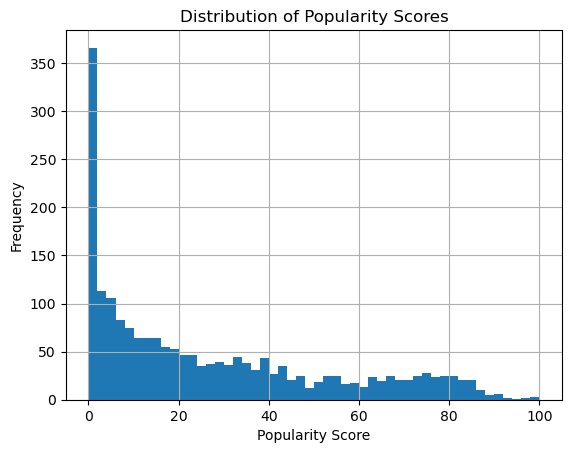

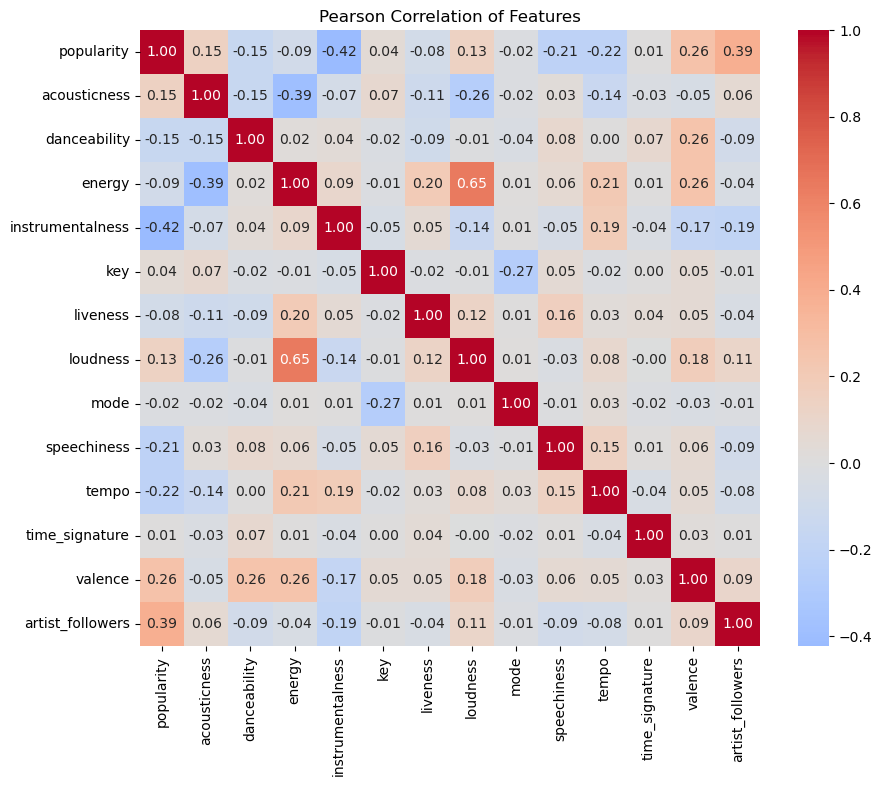

In [7]:
#replace with where the data may be held:
#df = pd.read_csv(r"C:\Users\jadcr\spotify_audio_features_v4.csv")
df = pd.read_csv("spotify_audio_features_v4.csv")

# try:
#     df = pd.read_csv("spotify_audio_features_v4.csv")
#     print("Read the CSV")
# except Exception as e:  # This catches any exception and stores it in variable e
#     print("Failed to read the CSV:", e)  

#Typical bad data handling and describing:
print(df.head())
df = df.drop_duplicates()
df = df.dropna()
#Prints if data is unclean (empty rowws etc): 
print(df.isnull().sum())
print(df.describe())

#Histogram of Popularity score distribution
df['popularity'].hist(bins=50)
plt.title('Distribution of Popularity Scores')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')
plt.show()

# Creating the heatmap using seaborn
df = df.drop(['track_id'], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Pearson Correlation of Features')
plt.show()


# Linear Regression Model

Linear Regression MSE: 409.29614991947074
Linear Regression R^2: 0.4140670823833418


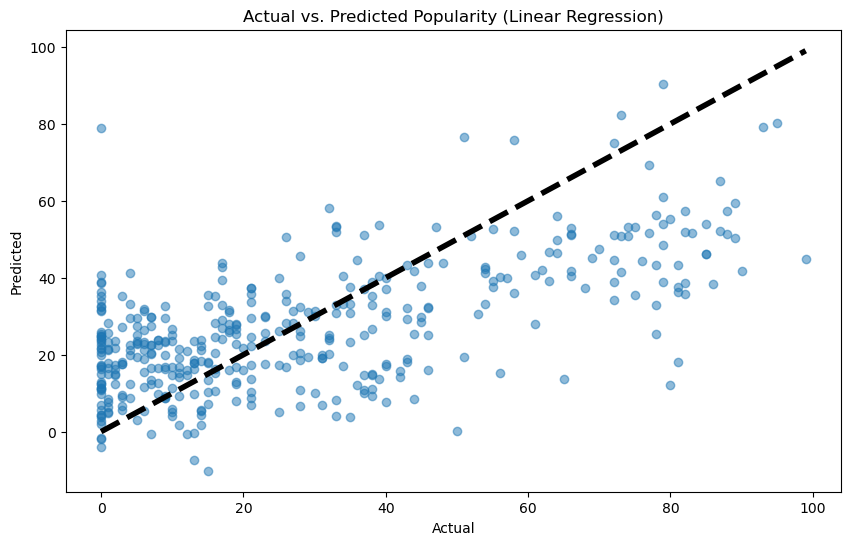

In [10]:
df = pd.read_csv("spotify_audio_features_v4.csv")

#Ensuring Target Variables defined
X = df.drop(['popularity', 'track_id'], axis=1)
y = df['popularity']
#in the evaluation of my paper I compare results with dropping initial artist followers
#if you wish to test the data in the same way, replace line 4 with: X = df.drop(['popularity', 'track_id','artist_followers'], axis=1)  # Adjust 'track_id' as per your DataFrame as standardisation doesnt work with non-numerical values

#Splitting Data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaler for data normalisation prior to model creation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

# Evaluating the model
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print(f"Linear Regression MSE: {mse_lin}")
print(f"Linear Regression R^2: {r2_lin}")

#Function to make graphs to visualise models
def plot_actual_vs_predicted(y_actual, y_predicted, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=4)  # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_lin, 'Actual vs. Predicted Popularity (Linear Regression)')


# Decision Tree Regression Model

Decision Tree Regression MSE: 489.5062344139651
Decision Tree Regression R^2: 0.2992413532886884


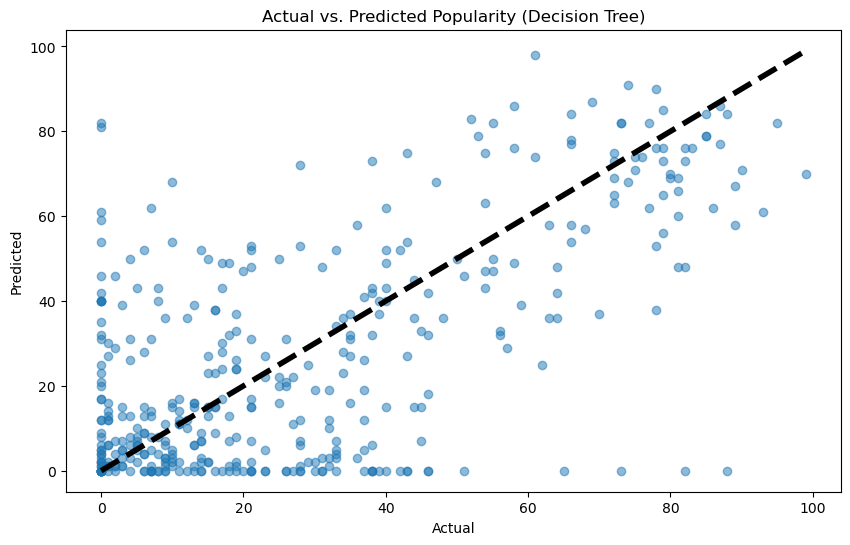

In [12]:

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred_tree = tree_reg.predict(X_test_scaled)

# Evaluating the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"Decision Tree Regression MSE: {mse_tree}")
print(f"Decision Tree Regression R^2: {r2_tree}")

#Recalling function from before to visualise model
plot_actual_vs_predicted(y_test, y_pred_tree, 'Actual vs. Predicted Popularity (Decision Tree)')

# Random Forest Model

Random Forest Regression MSE: 237.36263790523694
Random Forest Regression R^2: 0.6602006078279365


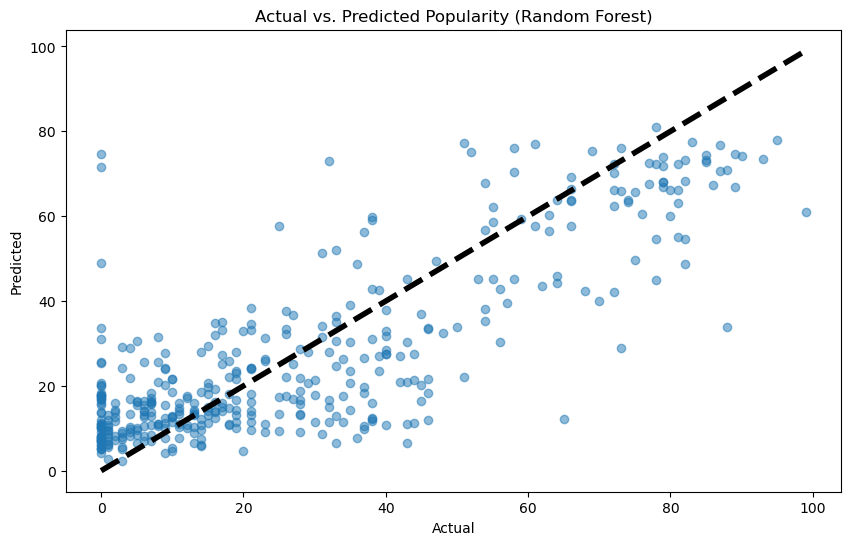

In [16]:

# Initialising/Fitting model standard set-up
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune n_estimators and other hyperparameters
rf_reg.fit(X_train_scaled, y_train)
y_pred_rf = rf_reg.predict(X_test_scaled)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression MSE: {mse_rf}")
print(f"Random Forest Regression R^2: {r2_rf}")

# Recalling function to visualize
plot_actual_vs_predicted(y_test, y_pred_rf, 'Actual vs. Predicted Popularity (Random Forest)')


# Random Forest Model Hyperparameter Tuning/Optimisation

In [25]:

#Defining a parameter grid with realistic computational limitations 
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20]
}

rf_reg = RandomForestRegressor(random_state=42)

#Using RandomizedSearchCV to use the param_grid to find optimal parameters
rf_random = RandomizedSearchCV(estimator=rf_reg, param_distributions=param_grid, n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1)

#Re-making model with RandomizedSearchCV's best parameters
rf_random.fit(X_train_scaled, y_train)

print(f"Best parameters: {rf_random.best_params_}")
print(f"Best score: {rf_random.best_score_}")

best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression MSE with best parameters: {mse_rf}")
print(f"Random Forest Regression R^2 with best parameters: {r2_rf}")


Best parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 50}
Best score: 0.6280526454700193
Random Forest Regression MSE with best parameters: 228.25624507870947
Random Forest Regression R^2 with best parameters: 0.6732369760392194


# Testing other ensemble methods (GradientBoost, CatBoost)

In [27]:
#For Gradient Boosting: (Note that param_grid rules change to RF)

# Define the parameter grid
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

gb = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=param_grid_gb, 
                               n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1)
gb_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for Gradient Boosting:", gb_random.best_params_)
print("Best score for Gradient Boosting:", gb_random.best_score_)

#For CatBoost: (Note again param_grid rules change to RF)

# Define the parameter grid
param_grid_cb = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

cb = CatBoostRegressor(silent=True, random_state=42)

# Initialize RandomizedSearchCV
cb_random = RandomizedSearchCV(estimator=cb, param_distributions=param_grid_cb, 
                                n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1)
cb_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for CatBoost:", cb_random.best_params_)
print("Best score for CatBoost:", cb_random.best_score_)

Best parameters for Gradient Boosting: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.1}
Best score for Gradient Boosting: 0.6151081395821005


The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.


Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 6}
Best score for CatBoost: 0.6298600379768633


# Final Optimisation: Cross Validating Ensemble Methods

In [28]:
# Models with their tuned parameters
models = {
    'RandomForest': RandomForestRegressor(n_estimators=500, min_samples_split=5, max_features='sqrt', max_depth=None, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=300, min_samples_split=4, min_samples_leaf=2, max_depth=5, learning_rate=0.01, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=100, learning_rate=0.1, depth=4, l2_leaf_reg=5, silent=True, random_state=42)
}

for name, model in models.items():
    # Compute the cross-validation score
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    
    # Convert MSE scores to RMSE
    rmse_scores = np.sqrt(-scores)
    
    print(f"{name}:")
    print(f"  RMSE: {np.mean(rmse_scores):.4f} (+/- {np.std(rmse_scores):.4f})")


RandomForest:
  RMSE: 16.5158 (+/- 3.1381)
GradientBoosting:
  RMSE: 16.9359 (+/- 3.4841)
CatBoost:
  RMSE: 16.9621 (+/- 3.5995)


# SHAP: Feature analysis for evaluative remarks

100%|===================| 1598/1600 [05:03<00:00]        

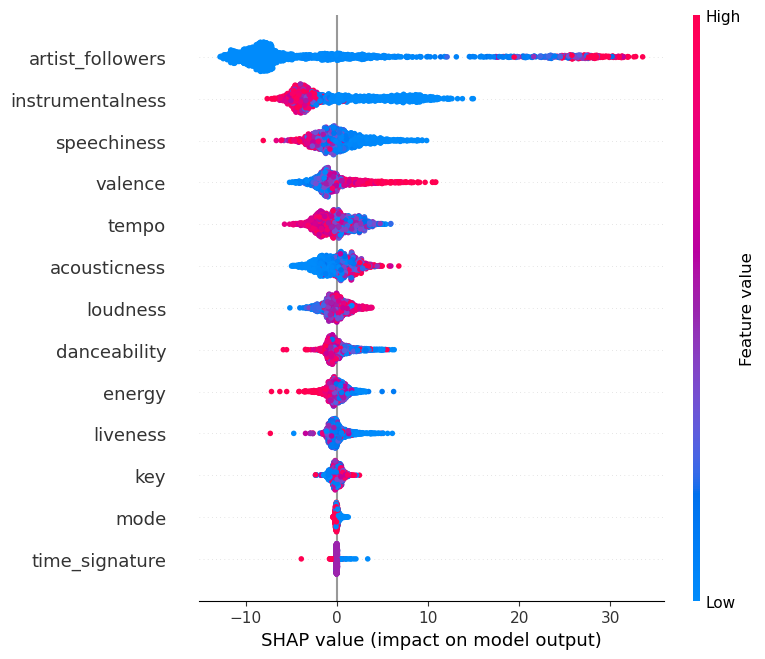

In [23]:
feature_names = df.drop(['popularity', 'track_id'], axis=1).columns.tolist()

# Initialize a SHAP explainer
explainer = shap.Explainer(best_rf, X_train_scaled)

# Compute SHAP values for the entire training dataset
shap_values = explainer(X_train_scaled, check_additivity=False)

# Summary plot to visualize feature importances
shap.summary_plot(shap_values, X_train_scaled,feature_names=feature_names)